# Introduction

This code is intended to create nice looking Bode plots for Matplotlib 2.x.x and above.  The main issue is creating appropriate and helpful tick marks.  If you have an older version of Matplotlib, you might want to stick with my original `random_bode_generator.ipynb`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
import control
rand = np.random.rand
plt.rcParams['font.size'] = 14
import matplotlib.ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

## Helper Functions

In [2]:
def assign_poles_to_bins(max_poles=5, bins=5):
    """Assign poles to frequency bins.  Each bin is assigned
    0,1, or 2 poles until max_poles is reached."""
    poles = [0]*bins
    
    for i in range(bins):
        num_poles = np.sum(poles)
        max_remaining = max_poles-num_poles
        if max_remaining <= 0:
            break
        elif max_remaining == 1:
            # the current bin can have 0 or 1 poles
            r = rand()
            if r > 0.5:
                poles[i] = 1
        elif max_remaining > 1:
            # current bin can have 0, 1, or 2 poles
            r = rand()
            if r > 0.7:
                poles[i] = 2
            elif r > 0.3:
                poles[i] = 1
        
    return poles

In [3]:
def assign_zeros_to_bins(poles):
    n = np.sum(poles)
    max_zeros = n-1
    bins = len(poles)
    zeros = [0]*bins
    
    for i, p_i in enumerate(poles):
        num_zeros = np.sum(zeros)
        max_remaining = max_zeros-num_zeros
        if p_i > 0:
            # no zeros in this bin 
            continue
        if max_remaining <= 0:
            break
        elif max_remaining == 1:
            # the current bin can have 0 or 1 poles
            r = rand()
            if r > 0.5:
                zeros[i] = 1
        elif max_remaining > 1:
            # current bin can have 0, 1, or 2 poles
            r = rand()
            if r > 0.7:
                zeros[i] = 2
            elif r > 0.3:
                zeros[i] = 1
        
    return zeros
    

In [4]:
def random_log_freq(low_exponent):
    """Generate a random frequency on the range 10**low_exponent - 10**(low_exponent+1)"""
    high_exponent = low_exponent + 1
    mid_exp = (low_exponent+high_exponent)/2
    act_exp = mid_exp + 0.7*(rand()-0.5)
    freq = 10**act_exp
    return freq

In [5]:
def pole_bins_to_den(poles):
    exponents = [None, -2, -1, 0, 1]# powers of 10 corresponding to each frequency bin
    
    if poles[0] == 1:
        G = control.TransferFunction(1,[1,0])
    elif poles[0] == 2:
        G = control.TransferFunction(1,[1,0,0])
    else:
        G = 1
    
    for p_i, exp_i in zip(poles[1:], exponents[1:]):
        if p_i == 0:
            # skip
            continue
        freq_i = random_log_freq(exp_i)
        w_i = 2.0*np.pi*freq_i
        
        if p_i == 1:
            G_i = control.TransferFunction(1,[1,w_i])
        elif p_i == 2:
            z_i = 0.8*rand()
            G_i = control.TransferFunction(1,[1,2*z_i*w_i,w_i**2])
            
        G *= G_i
        
    return np.squeeze(G.den)

In [6]:
def zero_bins_to_num(zeros):
    exponents = [None, -2, -1, 0, 1]# powers of 10 corresponding to each frequency bin
    
    if zeros[0] == 1:
        G = control.TransferFunction([1,0],1)
    elif zeros[0] == 2:
        G = control.TransferFunction([1,0,0],1)
    else:
        G = 1
    
    for z_i, exp_i in zip(zeros[1:], exponents[1:]):
        if z_i == 0:
            # skip
            continue
        freq_i = random_log_freq(exp_i)
        w_i = 2.0*np.pi*freq_i
        
        if z_i == 1:
            G_i = control.TransferFunction([1,w_i],1)
        elif z_i == 2:
            z_i = 0.8*rand()
            G_i = control.TransferFunction([1,2*z_i*w_i,w_i**2],1)
            
        G *= G_i
        
    if G == 1:
        # This is the default value if zeros is a list of 
        # all zeros: [0,0,0,...,0]
        return G
    else:
        return np.squeeze(G.num)

In [7]:
def random_Bode_TF(max_poles=5):
    plist = assign_poles_to_bins(max_poles=max_poles)
    while not np.any(plist):
        # We will not allow a TF that has no zeros
        plist = assign_poles_to_bins(max_poles=max_poles)
    
    zlist = assign_zeros_to_bins(plist)
    den = pole_bins_to_den(plist)
    num = zero_bins_to_num(zlist)
    G = control.TransferFunction(num,den)
    return G

In [8]:
def set_log_ticks(ax,nullx=False):
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
    ax.xaxis.set_major_locator(locmaj)
    if nullx:
        ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())

    mysubs = np.arange(0.1,0.99,0.1)
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=mysubs,numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

In [9]:
def mygrid(ax):
    ax.grid(1, which="both",ls=":", color='0.75')

In [10]:
def set_db_ticks(ax, db):
    dbmin = db.min()
    dbmax = db.max()
    # aim for less than 6 ticks in muliples of 10, 20, 40 , ...
    myspan = dbmax-dbmin
    maxticks = 6
    
    ticklist = [10,20,40,60,80]
    
    N = None
    
    for tick in ticklist:
        if myspan/tick < maxticks:
            N = tick
            break

    if N is None:
        N = 100
        
    majorLocator = MultipleLocator(N)
    majorFormatter = FormatStrFormatter('%d')

    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_formatter(majorFormatter)

In [11]:
def set_phase_ticks(ax, phase):
    phmin = phase.min()
    phmax = phase.max()
    # if 4 or 5 multiples of 45 is enough, use 45 as the base
    mul45 = (phmax-phmin)/45
    if mul45 < 6:
        N = 45
    elif mul45 < 12:
        N = 90
    else:
        N = 180
    majorLocator = MultipleLocator(N)
    majorFormatter = FormatStrFormatter('%d')

    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_formatter(majorFormatter)

In [12]:
def fix_phase(phase):
    """Double integrators seem to cause the phase to start at +180, 
    which is not right.  Since the code generates only strictly proper
    TFs with relative degree of at least 1, there should always be at 
    least one more pole than zero and the high frequency phase should 
    always be negative.  If the phase ends above 0, shift it by -360 
    degrees
    """
    if phase[-1] > 0:
        phase -= 360
    return phase

In [13]:
def plot_bode(G, f=None):
    if f is None:
        f = np.logspace(-4,3,1000)
    w = 2.0*np.pi*f
    s = 1.0j*w
    Gjw = G(s)
    db = 20.0*np.log10(abs(Gjw))
    phase_rad = np.angle(Gjw)
    phase_rad = np.unwrap(phase_rad)
    phase = phase_rad*180.0/np.pi
    phase = fix_phase(phase)
    
    plt.figure()
    plt.subplot(211)
    plt.semilogx(f,db)
    plt.ylabel('dB Mag.')
    ax = plt.gca()
    set_log_ticks(ax,nullx=True)
    set_db_ticks(ax, db)
    mygrid(ax)
    plt.subplot(212)
    plt.semilogx(f,phase)
    plt.ylabel('Phase (deg.)')
    plt.xlabel('Freq. (Hz)')
    ax = plt.gca()
    set_log_ticks(ax)
    set_phase_ticks(ax, phase)
    mygrid(ax)

In [14]:
def steady_state_fixed_sine(G,f,input_amp=1.0):
    w = 2*np.pi*f
    s = 1.0j*w
    Gjw = G(s)
    m = abs(Gjw)*input_amp
    phi = np.angle(Gjw)
    y_ss = '%0.4g sin(2*pi*%0.4g %+0.4g)' % (m,f,phi)
    return y_ss

## Usage

The function `random_Bode_TF` takes one optional input, the maximum number of poles.  The default for max. poles is 5.

### Option 1: Bode Sketching

Generate a random TF and show the TF.  You then sketch the Bode plot by hand.  Once you have sketched your TF, generate the Bode plot in Python to check your answer

In [31]:
G = random_Bode_TF(5)

In [32]:
G


   s^3 + 25.71 s^2 + 1070 s + 122.7
--------------------------------------
s^5 + 180.6 s^4 + 55.5 s^3 + 362.3 s^2

**Optional:** show the poles and zeros before sketching.

- If you think your instructor is kind and generous, then they 
  would either give you the TF in factored form or they would allow
  you to use a computer or your calculator to find the poles and zeros.
    - I expect my students to at least know how to use the quadratic 
      formula to find pole and zero locations.

#### Checking Your Answer

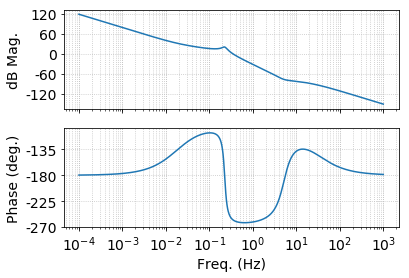

In [33]:
plot_bode(G)

In [18]:
G.pole()

array([-0.76267694+0.76636155j, -0.76267694-0.76636155j,
       -0.40585142+0.j        ,  0.00000000+0.j        ])

In [19]:
G.zero()

array([-234.14035463,  -15.62828057])

In [20]:
def preserve_G(G):
    """Print out the code to recreate a specific TF"""
    ns = np.squeeze(G.num)
    ds = np.squeeze(G.den)
    numstr = 'num = %s' % np.array2string(ns,separator=',')
    print(numstr)
    denstr = 'den = %s' % np.array2string(ds,separator=',')
    print(denstr)
    Gstr = 'G = control.TransferFunction(num,den)'
    print(Gstr)

In [34]:
preserve_G(G)

num = [  1.00000000e+00,  2.57105733e+01,  1.07045728e+03,  1.22747237e+02]
den = [   1.        , 180.58122926,  55.49887051, 362.29130746,   0.        ,
    0.        ]
G = control.TransferFunction(num,den)


### Option 2: System ID

Generate a random TF and then plot is Bode.  Based on the Bode, estimate the TF.  Then, once you have an estimate of the TF, check the answer.

In [22]:
G = random_Bode_TF(3)

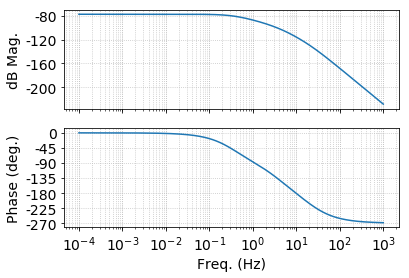

In [23]:
plot_bode(G)

#### Checking Your Answer

In [24]:
G


               1
-------------------------------
s^3 + 158.6 s^2 + 3737 s + 7643

In [25]:
G.pole()

array([-130.36126434,  -25.96010271,   -2.2583191 ])

In [26]:
np.abs(G.pole()/(2*pi))

array([ 20.74763961,   4.13167867,   0.35942265])

In [27]:
np.abs(G.zero()/(2*pi))

array([], dtype=float64)